In [1]:
import numpy as np
import pandas as pd
import gzip
import json
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_classification_df = pd.read_csv("released_dataset/train-classification.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

In [3]:
# stats about the labels
train_classification_df.groupby("category").count()

,user_id
category,
art,191
entertainment,323
fashion,299
food,511
gaming,13
health and lifestyle,503
mom and children,149
sports,113
tech,346


In [4]:
train_data_path = "released_dataset/training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile


In [5]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def preprocess_text(text: str):
    # lower casing Turkish Text
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []
train_usernames = []

for username, posts in username2posts_train.items():
  train_usernames.append(username)

  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  # joining the posts of each user with a \n
  user_post_captions = "\n".join(cleaned_captions)
  corpus.append(user_post_captions)


vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=5000)

# fit the vectorizer
vectorizer.fit(corpus)

test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
  test_usernames.append(username)
  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)

  user_post_captions = "\n".join(cleaned_captions)
  test_corpus.append(user_post_captions)


# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)

## Synthesis data

append biography of each account to caption and transofrm again to slightly shift the TF IDF to doulbe our train set

In [7]:
for username, posts in username2posts_train.items():
    train_usernames.append(username)

    # Aggregating posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        # Preprocess the caption
        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_captions.append(post_caption)

    # Preprocess the biography 
    biography = username2profile_train[username].get("biography", "")
    if biography:
        biography = preprocess_text(biography)
        cleaned_captions.append(biography)

    full_name = username2profile_train[username].get("full_name", "")
    if full_name:
        full_name = preprocess_text(full_name)
        cleaned_captions.append(full_name)
        
    # Joining the posts and biography with a \n
    user_post_captions = "\n".join(cleaned_captions)
    corpus.append(user_post_captions)

# Transform the data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]


In [8]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['abdullah', 'abone', 'about', ..., 'şık', 'şıklık', 'şıklığı'],
      dtype=object)

In [9]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head(2)

,abdullah,abone,about,acele,acil,activities,acı,ad,ada,adam,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şükür,şık,şıklık,şıklığı
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050596,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [10]:
import numpy as np

# Calculate sparsity
total_elements = df_tfidf.size
non_zero_elements = np.count_nonzero(df_tfidf)
sparsity = (1 - (non_zero_elements / total_elements)) * 100

print(f"Sparsity: {sparsity:.2f}%")

Sparsity: 95.53%


## Dimensionality Reduction for Spars Matrix

Number of components to retain 98% variance: 2132


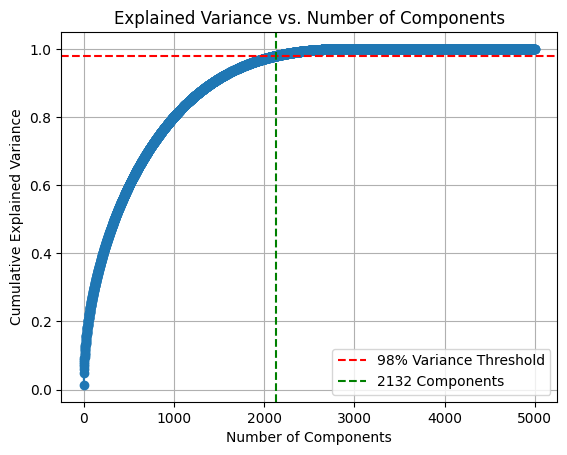

In [11]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt

# Initialize Truncated SVD 
max_components = min(x_post_train.shape)  
svd = TruncatedSVD(n_components=max_components, random_state=42)

# Fit the SVD 
svd.fit(x_post_train)

# Calculate the cumulative variance 
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Find the number of components required for 98% variance
n_components_percent = np.argmax(cumulative_variance >= 0.98) + 1

print(f"Number of components to retain 98% variance: {n_components_percent}")

# visualize the cumulative variance
plt.plot(range(1, max_components + 1), cumulative_variance, marker='o')
plt.axhline(y=0.98, color='r', linestyle='--', label="98% Variance Threshold")
plt.axvline(x=n_components_percent, color='g', linestyle='--', label=f"{n_components_percent} Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.legend()
plt.grid()
plt.show()

In [12]:
from sklearn.decomposition import TruncatedSVD

# Retain 98% of the variance
svd = TruncatedSVD(n_components=2132)  

# Fit SVD on the training data
svd.fit(x_post_train)

# Transform the training data
X_train_reduced = svd.transform(x_post_train)

# Print explained variance ratio to ensure coverage
explained_variance_ratio = svd.explained_variance_ratio_.sum()
print(f"Variance retained: {explained_variance_ratio * 100:.2f}%")


Variance retained: 97.97%


In [13]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train_reduced, y_train, test_size=0.2, stratify=y_train, random_state=42)

## Tuneing Ensemble Model

[I 2025-01-03 23:38:21,319] Using an existing study with name 'class2' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(
c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(
c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(
c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5

[I 2025-01-03 23:46:02,382] Trial 11 finished with value: 0.44492588369441277 and parameters: {'svm_c': 0.4978331459006681, 'svm_kernel': 'poly', 'svm_gamma': 0.06721947547184089, 'rf_n_estimators': 215, 'rf_max_depth': 17, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 9, 'rf_max_leaf_nodes': 163, 'rf_max_samples': 0.43919178335131115, 'lr_c': 0.024443369947336223}. Best is trial 11 with value: 0.44492588369441277.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 00:02:09,901] Trial 12 finished with value: 0.6437856328392246 and parameters: {'svm_c': 2.1516986589371654, 'svm_kernel': 'poly', 'svm_gamma': 0.022825756325479243, 'rf_n_estimators': 55, 'rf_max_depth': 15, 'rf_max_features': None, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 12, 'rf_max_leaf_nodes': 23, 'rf_max_samples': 0.9545137389352256, 'lr_c': 0.9928976297013876}. Best is trial 12 with value: 0.6437856328392246.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 00:08:52,419] Trial 17 finished with value: 0.8695553021664766 and parameters: {'svm_c': 3.1242355817396623, 'svm_kernel': 'linear', 'svm_gamma': 0.0003698041678779271, 'rf_n_estimators': 177, 'rf_max_depth': 41, 'rf_max_features': None, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 9, 'rf_max_leaf_nodes': 295, 'rf_max_samples': 0.4415614097350906, 'lr_c': 0.044896363749179706}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 00:09:53,525] Trial 14 finished with value: 0.46727480045610037 and parameters: {'svm_c': 2.3533680384593474, 'svm_kernel': 'poly', 'svm_gamma': 0.028709237163468192, 'rf_n_estimators': 229, 'rf_max_depth': 35, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 13, 'rf_min_samples_leaf': 11, 'rf_max_leaf_nodes': 152, 'rf_max_samples': 0.7162833155554962, 'lr_c': 0.035087981277920115}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 00:16:34,369] Trial 10 finished with value: 0.5090079817559864 and parameters: {'svm_c': 0.10029768613003467, 'svm_kernel': 'poly', 'svm_gamma': 0.08309953805579938, 'rf_n_estimators': 47, 'rf_max_depth': 15, 'rf_max_features': None, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 20, 'rf_max_leaf_nodes': 177, 'rf_max_samples': 0.9549618216342971, 'lr_c': 0.07228711806917984}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 00:31:34,331] Trial 16 finished with value: 0.8690992018244014 and parameters: {'svm_c': 3.272668914751221, 'svm_kernel': 'linear', 'svm_gamma': 0.6376740096092491, 'rf_n_estimators': 190, 'rf_max_depth': 49, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 8, 'rf_max_leaf_nodes': 173, 'rf_max_samples': 0.1581455061790605, 'lr_c': 0.010362870626773352}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 00:32:33,477] Trial 15 finished with value: 0.8389965792474344 and parameters: {'svm_c': 0.10781363498086043, 'svm_kernel': 'rbf', 'svm_gamma': 0.0011853888037683389, 'rf_n_estimators': 135, 'rf_max_depth': 5, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 18, 'rf_max_leaf_nodes': 25, 'rf_max_samples': 0.7602321967085656, 'lr_c': 7.772978133109165}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 00:40:00,463] Trial 19 finished with value: 0.6923603192702393 and parameters: {'svm_c': 0.9426956606728323, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.002506331486267225, 'rf_n_estimators': 189, 'rf_max_depth': 11, 'rf_max_features': 'log2', 'rf_min_samples_split': 13, 'rf_min_samples_leaf': 7, 'rf_max_leaf_nodes': 221, 'rf_max_samples': 0.8005998704193328, 'lr_c': 0.01652104475816779}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 00:46:27,212] Trial 13 finished with value: 0.6241733181299886 and parameters: {'svm_c': 1.3170893274288764, 'svm_kernel': 'poly', 'svm_gamma': 0.003130722158767201, 'rf_n_estimators': 249, 'rf_max_depth': 37, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 15, 'rf_min_samples_leaf': 18, 'rf_max_leaf_nodes': 32, 'rf_max_samples': 0.6994397315453083, 'lr_c': 0.21855225445877388}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 00:50:05,210] Trial 18 finished with value: 0.703078677309008 and parameters: {'svm_c': 0.16886324662253266, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.8889473139357478, 'rf_n_estimators': 113, 'rf_max_depth': 47, 'rf_max_features': None, 'rf_min_samples_split': 17, 'rf_min_samples_leaf': 16, 'rf_max_leaf_nodes': 164, 'rf_max_samples': 0.2718421205362245, 'lr_c': 0.042697762796280764}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 00:56:04,986] Trial 20 finished with value: 0.5090079817559863 and parameters: {'svm_c': 1.0434700539207629, 'svm_kernel': 'poly', 'svm_gamma': 0.004785903918976891, 'rf_n_estimators': 38, 'rf_max_depth': 25, 'rf_max_features': None, 'rf_min_samples_split': 17, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 47, 'rf_max_samples': 0.9218551540921639, 'lr_c': 0.030368784350694}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 00:57:47,512] Trial 21 finished with value: 0.625769669327252 and parameters: {'svm_c': 5.363524574253293, 'svm_kernel': 'poly', 'svm_gamma': 0.0003668469021734156, 'rf_n_estimators': 145, 'rf_max_depth': 31, 'rf_max_features': None, 'rf_min_samples_split': 14, 'rf_min_samples_leaf': 7, 'rf_max_leaf_nodes': 229, 'rf_max_samples': 0.11595071471219451, 'lr_c': 0.3340267120750863}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 01:07:17,588] Trial 22 finished with value: 0.7003420752565563 and parameters: {'svm_c': 5.089685650167656, 'svm_kernel': 'poly', 'svm_gamma': 0.0009619528085843419, 'rf_n_estimators': 244, 'rf_max_depth': 25, 'rf_max_features': None, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 10, 'rf_max_leaf_nodes': 57, 'rf_max_samples': 0.8397686185989628, 'lr_c': 0.7026575427886104}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 01:20:37,684] Trial 23 finished with value: 0.83557582668187 and parameters: {'svm_c': 0.4842562758827691, 'svm_kernel': 'linear', 'svm_gamma': 0.03517230174005111, 'rf_n_estimators': 110, 'rf_max_depth': 31, 'rf_max_features': None, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 16, 'rf_max_leaf_nodes': 47, 'rf_max_samples': 0.834484135267006, 'lr_c': 9.267491526497377}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 01:23:16,634] Trial 24 finished with value: 0.6811858608893957 and parameters: {'svm_c': 0.14828006761585397, 'svm_kernel': 'poly', 'svm_gamma': 0.003622278346414634, 'rf_n_estimators': 133, 'rf_max_depth': 29, 'rf_max_features': None, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 7, 'rf_max_leaf_nodes': 178, 'rf_max_samples': 0.858213772649565, 'lr_c': 0.08169278065489759}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 01:28:32,390] Trial 25 finished with value: 0.6982896237172178 and parameters: {'svm_c': 0.5699771808437275, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.00013016800479769992, 'rf_n_estimators': 138, 'rf_max_depth': 43, 'rf_max_features': None, 'rf_min_samples_split': 19, 'rf_min_samples_leaf': 20, 'rf_max_leaf_nodes': 170, 'rf_max_samples': 0.47147466975794805, 'lr_c': 1.0922383425730384}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 01:31:54,262] Trial 26 finished with value: 0.34800456100342075 and parameters: {'svm_c': 0.379368929206616, 'svm_kernel': 'poly', 'svm_gamma': 0.0004541937561452726, 'rf_n_estimators': 18, 'rf_max_depth': 31, 'rf_max_features': 'log2', 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 13, 'rf_max_leaf_nodes': 207, 'rf_max_samples': 0.14435401647216206, 'lr_c': 0.0343290097103507}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 01:41:58,249] Trial 27 finished with value: 0.7297605473204105 and parameters: {'svm_c': 0.16684438928636494, 'svm_kernel': 'linear', 'svm_gamma': 0.00013600974460691162, 'rf_n_estimators': 284, 'rf_max_depth': 15, 'rf_max_features': 'log2', 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 5, 'rf_max_leaf_nodes': 275, 'rf_max_samples': 0.816385973845935, 'lr_c': 0.02509574295663527}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 01:45:41,822] Trial 28 finished with value: 0.7181299885974914 and parameters: {'svm_c': 3.3206064746841912, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.0005026826447397121, 'rf_n_estimators': 270, 'rf_max_depth': 9, 'rf_max_features': None, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 8, 'rf_max_leaf_nodes': 197, 'rf_max_samples': 0.6099415272727953, 'lr_c': 0.26047021944568044}. Best is trial 17 with value: 0.8695553021664766.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 02:03:36,980] Trial 29 finished with value: 0.8768529076396808 and parameters: {'svm_c': 9.28312226573499, 'svm_kernel': 'linear', 'svm_gamma': 0.00012818167519488074, 'rf_n_estimators': 295, 'rf_max_depth': 27, 'rf_max_features': 'log2', 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 293, 'rf_max_samples': 0.45343770475715867, 'lr_c': 0.3141571105431345}. Best is trial 29 with value: 0.8768529076396808.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 02:23:39,666] Trial 30 finished with value: 0.8709236031927023 and parameters: {'svm_c': 7.826097881936262, 'svm_kernel': 'linear', 'svm_gamma': 0.00047823926308889126, 'rf_n_estimators': 296, 'rf_max_depth': 47, 'rf_max_features': 'log2', 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 5, 'rf_max_leaf_nodes': 270, 'rf_max_samples': 0.2502597344503684, 'lr_c': 0.010421048860965575}. Best is trial 29 with value: 0.8768529076396808.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 02:28:40,071] Trial 31 finished with value: 0.8734321550741162 and parameters: {'svm_c': 6.6025000087182555, 'svm_kernel': 'linear', 'svm_gamma': 0.00012104212575221917, 'rf_n_estimators': 297, 'rf_max_depth': 49, 'rf_max_features': 'log2', 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 269, 'rf_max_samples': 0.4468641514697658, 'lr_c': 0.013454468717820184}. Best is trial 29 with value: 0.8768529076396808.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 02:45:48,627] Trial 32 finished with value: 0.8738882554161915 and parameters: {'svm_c': 7.8243557424730525, 'svm_kernel': 'linear', 'svm_gamma': 0.00016016982846810593, 'rf_n_estimators': 174, 'rf_max_depth': 49, 'rf_max_features': 'log2', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 294, 'rf_max_samples': 0.42988120926077633, 'lr_c': 0.013485410760704294}. Best is trial 29 with value: 0.8768529076396808.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 03:06:33,950] Trial 33 finished with value: 0.8722919042189281 and parameters: {'svm_c': 9.052690122075614, 'svm_kernel': 'linear', 'svm_gamma': 0.00010719284426853431, 'rf_n_estimators': 180, 'rf_max_depth': 49, 'rf_max_features': 'log2', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 283, 'rf_max_samples': 0.46362370571288347, 'lr_c': 0.011218778455198164}. Best is trial 29 with value: 0.8768529076396808.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 03:09:02,761] Trial 34 finished with value: 0.8722919042189282 and parameters: {'svm_c': 9.242885627718538, 'svm_kernel': 'linear', 'svm_gamma': 0.00010243362511007389, 'rf_n_estimators': 181, 'rf_max_depth': 49, 'rf_max_features': 'log2', 'rf_min_samples_split': 20, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 292, 'rf_max_samples': 0.48568566818979053, 'lr_c': 0.010550681664342752}. Best is trial 29 with value: 0.8768529076396808.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 03:28:47,254] Trial 35 finished with value: 0.8716077537058153 and parameters: {'svm_c': 7.449690760804811, 'svm_kernel': 'linear', 'svm_gamma': 0.7838345908456005, 'rf_n_estimators': 197, 'rf_max_depth': 49, 'rf_max_features': 'log2', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 287, 'rf_max_samples': 0.29356238038953797, 'lr_c': 0.013346458458661961}. Best is trial 29 with value: 0.8768529076396808.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 03:33:36,394] Trial 36 finished with value: 0.8748004561003422 and parameters: {'svm_c': 8.109865719731546, 'svm_kernel': 'linear', 'svm_gamma': 0.4287795769717839, 'rf_n_estimators': 298, 'rf_max_depth': 49, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 299, 'rf_max_samples': 0.3145593550207163, 'lr_c': 0.010221041767252987}. Best is trial 29 with value: 0.8768529076396808.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 03:51:31,848] Trial 37 finished with value: 0.87115165336374 and parameters: {'svm_c': 9.916067680494667, 'svm_kernel': 'linear', 'svm_gamma': 0.8422889053413828, 'rf_n_estimators': 204, 'rf_max_depth': 49, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 14, 'rf_max_leaf_nodes': 299, 'rf_max_samples': 0.32746700236804765, 'lr_c': 0.012469689196682072}. Best is trial 29 with value: 0.8768529076396808.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 04:11:43,819] Trial 38 finished with value: 0.8752565564424172 and parameters: {'svm_c': 8.006338764615341, 'svm_kernel': 'linear', 'svm_gamma': 0.17207853333873155, 'rf_n_estimators': 185, 'rf_max_depth': 49, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 295, 'rf_max_samples': 0.3102139628454715, 'lr_c': 0.08965899814750226}. Best is trial 29 with value: 0.8768529076396808.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 04:16:49,075] Trial 39 finished with value: 0.8779931584948688 and parameters: {'svm_c': 9.96412445958313, 'svm_kernel': 'linear', 'svm_gamma': 0.0002067102119783412, 'rf_n_estimators': 300, 'rf_max_depth': 41, 'rf_max_features': 'log2', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 276, 'rf_max_samples': 0.30852097374093923, 'lr_c': 2.915193736936337}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 04:34:00,240] Trial 40 finished with value: 0.8768529076396808 and parameters: {'svm_c': 9.932632682867297, 'svm_kernel': 'linear', 'svm_gamma': 0.00010736896820641935, 'rf_n_estimators': 295, 'rf_max_depth': 41, 'rf_max_features': 'log2', 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 296, 'rf_max_samples': 0.33556855878466324, 'lr_c': 2.871188335123587}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 04:55:00,884] Trial 41 finished with value: 0.8775370581527936 and parameters: {'svm_c': 7.319538134726551, 'svm_kernel': 'linear', 'svm_gamma': 0.00010821088214441932, 'rf_n_estimators': 291, 'rf_max_depth': 45, 'rf_max_features': 'log2', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 256, 'rf_max_samples': 0.3195548847773305, 'lr_c': 3.111258448308557}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 04:57:16,042] Trial 42 finished with value: 0.8759407069555302 and parameters: {'svm_c': 9.960864178508015, 'svm_kernel': 'linear', 'svm_gamma': 0.00011292993426155484, 'rf_n_estimators': 264, 'rf_max_depth': 21, 'rf_max_features': 'log2', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 252, 'rf_max_samples': 0.32291723041300424, 'lr_c': 3.0697051780157993}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 05:08:56,880] Trial 44 finished with value: 0.7979475484606613 and parameters: {'svm_c': 5.784936753651433, 'svm_kernel': 'rbf', 'svm_gamma': 0.0002188614635735542, 'rf_n_estimators': 262, 'rf_max_depth': 41, 'rf_max_features': 'log2', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 252, 'rf_max_samples': 0.34376306897055553, 'lr_c': 2.9056009566756176}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 05:16:43,318] Trial 43 finished with value: 0.8761687571265678 and parameters: {'svm_c': 5.130326638535789, 'svm_kernel': 'linear', 'svm_gamma': 0.0001709955698925241, 'rf_n_estimators': 268, 'rf_max_depth': 21, 'rf_max_features': 'log2', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 250, 'rf_max_samples': 0.5525938475118095, 'lr_c': 2.782208379322989}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 05:17:35,865] Trial 45 finished with value: 0.7049030786773091 and parameters: {'svm_c': 4.352174350366948, 'svm_kernel': 'rbf', 'svm_gamma': 0.0002016938701419087, 'rf_n_estimators': 275, 'rf_max_depth': 21, 'rf_max_features': 'log2', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 5, 'rf_max_leaf_nodes': 255, 'rf_max_samples': 0.5773139609543347, 'lr_c': 0.1542002940711344}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 05:37:37,114] Trial 46 finished with value: 0.8695553021664766 and parameters: {'svm_c': 4.679318193240451, 'svm_kernel': 'rbf', 'svm_gamma': 0.22651139276996599, 'rf_n_estimators': 264, 'rf_max_depth': 21, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 5, 'rf_max_leaf_nodes': 255, 'rf_max_samples': 0.3650270335259944, 'lr_c': 4.638459909705737}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 05:55:33,836] Trial 47 finished with value: 0.8624857468643101 and parameters: {'svm_c': 4.917546835307395, 'svm_kernel': 'rbf', 'svm_gamma': 0.1917929951542821, 'rf_n_estimators': 265, 'rf_max_depth': 21, 'rf_max_features': 'log2', 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 5, 'rf_max_leaf_nodes': 249, 'rf_max_samples': 0.3766314902050244, 'lr_c': 0.11945995737662114}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 05:59:06,081] Trial 48 finished with value: 0.8697833523375144 and parameters: {'svm_c': 4.697319683915631, 'svm_kernel': 'rbf', 'svm_gamma': 0.24269677663406, 'rf_n_estimators': 263, 'rf_max_depth': 41, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 5, 'rf_max_leaf_nodes': 247, 'rf_max_samples': 0.5768771943693601, 'lr_c': 0.10875973384432747}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 06:18:49,745] Trial 49 finished with value: 0.8638540478905359 and parameters: {'svm_c': 4.646360362386556, 'svm_kernel': 'rbf', 'svm_gamma': 0.19238280380848596, 'rf_n_estimators': 267, 'rf_max_depth': 21, 'rf_max_features': 'log2', 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 5, 'rf_max_leaf_nodes': 249, 'rf_max_samples': 0.5629593241481249, 'lr_c': 3.802863073629291}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 06:28:31,257] Trial 51 finished with value: 0.8077537058152794 and parameters: {'svm_c': 4.879168638340227, 'svm_kernel': 'rbf', 'svm_gamma': 0.0002307203520158683, 'rf_n_estimators': 269, 'rf_max_depth': 41, 'rf_max_features': 'log2', 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 5, 'rf_max_leaf_nodes': 250, 'rf_max_samples': 0.38258406816478807, 'lr_c': 3.7998242581681376}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 06:36:23,696] Trial 52 finished with value: 0.7908779931584949 and parameters: {'svm_c': 4.881542246943675, 'svm_kernel': 'rbf', 'svm_gamma': 0.00022799003983497892, 'rf_n_estimators': 273, 'rf_max_depth': 41, 'rf_max_features': 'log2', 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 5, 'rf_max_leaf_nodes': 256, 'rf_max_samples': 0.38321705973576614, 'lr_c': 2.6747569226738808}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 06:36:23,977] Trial 50 finished with value: 0.8684150513112885 and parameters: {'svm_c': 5.190095209555521, 'svm_kernel': 'rbf', 'svm_gamma': 0.19842068604056962, 'rf_n_estimators': 273, 'rf_max_depth': 41, 'rf_max_features': 'log2', 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 5, 'rf_max_leaf_nodes': 255, 'rf_max_samples': 0.3737988188282777, 'lr_c': 4.111649065397922}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 06:43:01,023] Trial 53 finished with value: 0.7961231470923603 and parameters: {'svm_c': 4.276860665136129, 'svm_kernel': 'rbf', 'svm_gamma': 0.0009779860841667477, 'rf_n_estimators': 278, 'rf_max_depth': 37, 'rf_max_features': 'log2', 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 5, 'rf_max_leaf_nodes': 247, 'rf_max_samples': 0.3884274650811622, 'lr_c': 2.85686765198321}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 06:47:16,184] Trial 54 finished with value: 0.8205245153933867 and parameters: {'svm_c': 4.227121846483024, 'svm_kernel': 'rbf', 'svm_gamma': 0.000990775168824042, 'rf_n_estimators': 230, 'rf_max_depth': 37, 'rf_max_features': 'log2', 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 5, 'rf_max_leaf_nodes': 131, 'rf_max_samples': 0.22415071311094023, 'lr_c': 5.3651551857553015}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 07:07:24,425] Trial 55 finished with value: 0.8743443557582669 and parameters: {'svm_c': 4.199091756462259, 'svm_kernel': 'linear', 'svm_gamma': 0.0009119944288860304, 'rf_n_estimators': 225, 'rf_max_depth': 37, 'rf_max_features': 'log2', 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 6, 'rf_max_leaf_nodes': 126, 'rf_max_samples': 0.21335477785073148, 'lr_c': 5.001172049842021}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 07:20:52,244] Trial 56 finished with value: 0.8645381984036489 and parameters: {'svm_c': 2.158211912222401, 'svm_kernel': 'linear', 'svm_gamma': 0.0009012963307384434, 'rf_n_estimators': 229, 'rf_max_depth': 37, 'rf_max_features': 'log2', 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 6, 'rf_max_leaf_nodes': 236, 'rf_max_samples': 0.22401109647997444, 'lr_c': 1.449151465629005}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 07:29:26,839] Trial 57 finished with value: 0.87115165336374 and parameters: {'svm_c': 2.6239679852219937, 'svm_kernel': 'linear', 'svm_gamma': 0.0009154367438312434, 'rf_n_estimators': 229, 'rf_max_depth': 35, 'rf_max_features': 'log2', 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 6, 'rf_max_leaf_nodes': 232, 'rf_max_samples': 0.24387726979109314, 'lr_c': 1.2516510587351473}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 07:47:20,412] Trial 58 finished with value: 0.8622576966932725 and parameters: {'svm_c': 2.057418626644743, 'svm_kernel': 'linear', 'svm_gamma': 0.0008967603749671212, 'rf_n_estimators': 230, 'rf_max_depth': 35, 'rf_max_features': 'log2', 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 6, 'rf_max_leaf_nodes': 140, 'rf_max_samples': 0.2173122595125826, 'lr_c': 1.5515221388916742}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 08:02:21,480] Trial 59 finished with value: 0.8599771949828963 and parameters: {'svm_c': 1.7892376502671987, 'svm_kernel': 'linear', 'svm_gamma': 0.00028616243200569415, 'rf_n_estimators': 228, 'rf_max_depth': 35, 'rf_max_features': 'log2', 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 6, 'rf_max_leaf_nodes': 133, 'rf_max_samples': 0.2209654221713735, 'lr_c': 1.4949160116078475}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 08:11:07,248] Trial 60 finished with value: 0.8761687571265678 and parameters: {'svm_c': 6.295066279214638, 'svm_kernel': 'linear', 'svm_gamma': 0.0009214771266324096, 'rf_n_estimators': 243, 'rf_max_depth': 37, 'rf_max_features': 'log2', 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 6, 'rf_max_leaf_nodes': 123, 'rf_max_samples': 0.20743241921831032, 'lr_c': 2.023259799024464}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 08:29:22,120] Trial 61 finished with value: 0.8618015963511974 and parameters: {'svm_c': 1.9272704054523442, 'svm_kernel': 'linear', 'svm_gamma': 0.0008290293965828912, 'rf_n_estimators': 234, 'rf_max_depth': 35, 'rf_max_features': 'log2', 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 6, 'rf_max_leaf_nodes': 118, 'rf_max_samples': 0.19370962704636957, 'lr_c': 1.692186041096927}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 08:33:39,756] Trial 62 finished with value: 0.867502850627138 and parameters: {'svm_c': 2.3125757328901697, 'svm_kernel': 'linear', 'svm_gamma': 0.000752609872117316, 'rf_n_estimators': 233, 'rf_max_depth': 35, 'rf_max_features': 'log2', 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 6, 'rf_max_leaf_nodes': 129, 'rf_max_samples': 0.24499969764801863, 'lr_c': 1.7374574094651372}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 09:05:59,795] Trial 63 finished with value: 0.8622576966932725 and parameters: {'svm_c': 1.9054512441536533, 'svm_kernel': 'linear', 'svm_gamma': 0.000662055515430099, 'rf_n_estimators': 232, 'rf_max_depth': 35, 'rf_max_features': 'log2', 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 126, 'rf_max_samples': 0.22719241653125422, 'lr_c': 1.4700619630399405}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 09:28:03,168] Trial 64 finished with value: 0.8725199543899658 and parameters: {'svm_c': 2.6684945064250765, 'svm_kernel': 'linear', 'svm_gamma': 0.008223016358677235, 'rf_n_estimators': 245, 'rf_max_depth': 45, 'rf_max_features': 'log2', 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 92, 'rf_max_samples': 0.6611071474272475, 'lr_c': 1.8425551130190654}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 09:42:55,669] Trial 65 finished with value: 0.8770809578107184 and parameters: {'svm_c': 6.664709602454767, 'svm_kernel': 'linear', 'svm_gamma': 0.0016844186768767194, 'rf_n_estimators': 246, 'rf_max_depth': 25, 'rf_max_features': 'log2', 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 221, 'rf_max_samples': 0.5160816065774133, 'lr_c': 1.8889057906529088}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 10:12:41,323] Trial 66 finished with value: 0.8770809578107184 and parameters: {'svm_c': 6.3785331522557, 'svm_kernel': 'linear', 'svm_gamma': 0.0003088688969163964, 'rf_n_estimators': 246, 'rf_max_depth': 45, 'rf_max_features': 'log2', 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 219, 'rf_max_samples': 0.51022863859205, 'lr_c': 0.4400009422900342}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 10:34:06,293] Trial 67 finished with value: 0.8586088939566705 and parameters: {'svm_c': 1.6689020792823404, 'svm_kernel': 'linear', 'svm_gamma': 0.0003014034512903032, 'rf_n_estimators': 286, 'rf_max_depth': 45, 'rf_max_features': 'log2', 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 214, 'rf_max_samples': 0.6226378973957375, 'lr_c': 0.46245378828053874}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 10:48:10,793] Trial 68 finished with value: 0.8775370581527936 and parameters: {'svm_c': 6.039248159840435, 'svm_kernel': 'linear', 'svm_gamma': 0.01256675631344053, 'rf_n_estimators': 248, 'rf_max_depth': 45, 'rf_max_features': 'log2', 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 91, 'rf_max_samples': 0.630554162700065, 'lr_c': 0.5117802507779462}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 11:06:54,411] Trial 69 finished with value: 0.8763968072976056 and parameters: {'svm_c': 6.393638040458184, 'svm_kernel': 'linear', 'svm_gamma': 0.007335856178986611, 'rf_n_estimators': 248, 'rf_max_depth': 45, 'rf_max_features': 'log2', 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 94, 'rf_max_samples': 0.5318694155014232, 'lr_c': 0.5383364180711872}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 11:09:51,407] Trial 70 finished with value: 0.8775370581527936 and parameters: {'svm_c': 6.355852736378394, 'svm_kernel': 'linear', 'svm_gamma': 0.0020698042993734607, 'rf_n_estimators': 249, 'rf_max_depth': 45, 'rf_max_features': 'log2', 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 105, 'rf_max_samples': 0.6319566349760031, 'lr_c': 0.595708136874737}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 11:26:14,775] Trial 72 finished with value: 0.7416191562143671 and parameters: {'svm_c': 6.422174046615604, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.0003387315772643987, 'rf_n_estimators': 250, 'rf_max_depth': 45, 'rf_max_features': 'log2', 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 101, 'rf_max_samples': 0.6832878204738037, 'lr_c': 0.6403226440877015}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 11:29:04,631] Trial 71 finished with value: 0.8775370581527936 and parameters: {'svm_c': 7.121955508211757, 'svm_kernel': 'linear', 'svm_gamma': 0.0019141600594149953, 'rf_n_estimators': 249, 'rf_max_depth': 45, 'rf_max_features': 'log2', 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 274, 'rf_max_samples': 0.511463642637216, 'lr_c': 0.6316780042395508}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 11:34:25,835] Trial 73 finished with value: 0.7377423033067275 and parameters: {'svm_c': 6.075692715007398, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.0002916526967464376, 'rf_n_estimators': 249, 'rf_max_depth': 45, 'rf_max_features': 'log2', 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 95, 'rf_max_samples': 0.5094208499592742, 'lr_c': 0.6334942776007801}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 11:50:04,764] Trial 74 finished with value: 0.876624857468643 and parameters: {'svm_c': 6.28700963697728, 'svm_kernel': 'linear', 'svm_gamma': 0.0018483383343525892, 'rf_n_estimators': 288, 'rf_max_depth': 27, 'rf_max_features': 'log2', 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 277, 'rf_max_samples': 0.5235637746734975, 'lr_c': 0.6075046093188144}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 11:51:43,546] Trial 75 finished with value: 0.7379703534777651 and parameters: {'svm_c': 6.6723643270415804, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.0018423273197922029, 'rf_n_estimators': 288, 'rf_max_depth': 25, 'rf_max_features': 'log2', 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 276, 'rf_max_samples': 0.5177361637203519, 'lr_c': 0.6594163569636592}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 11:58:09,412] Trial 76 finished with value: 0.7397947548460662 and parameters: {'svm_c': 6.620813730876979, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.0020347144258546007, 'rf_n_estimators': 288, 'rf_max_depth': 27, 'rf_max_features': 'log2', 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_max_leaf_nodes': 209, 'rf_max_samples': 0.5179200704672374, 'lr_c': 0.6821250101337517}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 12:05:32,262] Trial 77 finished with value: 0.7377423033067275 and parameters: {'svm_c': 6.7538456281493495, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.0022931765652830396, 'rf_n_estimators': 286, 'rf_max_depth': 27, 'rf_max_features': 'log2', 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 8, 'rf_max_leaf_nodes': 281, 'rf_max_samples': 0.5197194095363888, 'lr_c': 0.795997478220731}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 12:09:47,695] Trial 78 finished with value: 0.7438996579247433 and parameters: {'svm_c': 3.570125715526969, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.0017356870569043383, 'rf_n_estimators': 253, 'rf_max_depth': 27, 'rf_max_features': None, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 8, 'rf_max_leaf_nodes': 192, 'rf_max_samples': 0.5173095922453884, 'lr_c': 0.7307420554451921}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 12:17:30,716] Trial 79 finished with value: 0.7477765108323833 and parameters: {'svm_c': 3.5274658043873277, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.0018130258812425917, 'rf_n_estimators': 72, 'rf_max_depth': 25, 'rf_max_features': None, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 8, 'rf_max_leaf_nodes': 195, 'rf_max_samples': 0.5079951295102945, 'lr_c': 0.8249434013399486}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 12:21:32,080] Trial 80 finished with value: 0.7206385404789053 and parameters: {'svm_c': 3.5900566490626242, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.01828304093136595, 'rf_n_estimators': 211, 'rf_max_depth': 27, 'rf_max_features': 'log2', 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 11, 'rf_max_leaf_nodes': 272, 'rf_max_samples': 0.5115359140434877, 'lr_c': 0.7901072107492568}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 12:42:24,104] Trial 82 finished with value: 0.748460661345496 and parameters: {'svm_c': 3.518907734547981, 'svm_kernel': 'sigmoid', 'svm_gamma': 0.0019073594578952885, 'rf_n_estimators': 214, 'rf_max_depth': 43, 'rf_max_features': None, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 8, 'rf_max_leaf_nodes': 71, 'rf_max_samples': 0.7393042305769746, 'lr_c': 0.9346408470381865}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 12:43:39,592] Trial 81 finished with value: 0.8706955530216648 and parameters: {'svm_c': 3.511918191232225, 'svm_kernel': 'linear', 'svm_gamma': 0.0025921471284990213, 'rf_n_estimators': 214, 'rf_max_depth': 27, 'rf_max_features': None, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 8, 'rf_max_leaf_nodes': 69, 'rf_max_samples': 0.7361116753136159, 'lr_c': 0.875768652979285}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 12:49:50,911] Trial 83 finished with value: 0.7267958950969213 and parameters: {'svm_c': 7.325754470449711, 'svm_kernel': 'poly', 'svm_gamma': 0.0017589041952419694, 'rf_n_estimators': 102, 'rf_max_depth': 43, 'rf_max_features': None, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 8, 'rf_max_leaf_nodes': 196, 'rf_max_samples': 0.7170220644416803, 'lr_c': 0.4136864586464371}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 12:57:32,725] Trial 84 finished with value: 0.6996579247434436 and parameters: {'svm_c': 3.470058095533405, 'svm_kernel': 'poly', 'svm_gamma': 0.014062227566998958, 'rf_n_estimators': 208, 'rf_max_depth': 43, 'rf_max_features': None, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 8, 'rf_max_leaf_nodes': 184, 'rf_max_samples': 0.7435803717658287, 'lr_c': 0.8309672531744728}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 13:02:23,656] Trial 85 finished with value: 0.6554161915621436 and parameters: {'svm_c': 3.0507197848608185, 'svm_kernel': 'poly', 'svm_gamma': 0.019079645251002295, 'rf_n_estimators': 208, 'rf_max_depth': 43, 'rf_max_features': None, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 8, 'rf_max_leaf_nodes': 197, 'rf_max_samples': 0.726986659686574, 'lr_c': 0.40204130496514207}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 13:09:29,922] Trial 86 finished with value: 0.6795895096921323 and parameters: {'svm_c': 3.5690483769820776, 'svm_kernel': 'poly', 'svm_gamma': 0.019810415079653722, 'rf_n_estimators': 216, 'rf_max_depth': 43, 'rf_max_features': None, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 11, 'rf_max_leaf_nodes': 265, 'rf_max_samples': 0.41834432608824146, 'lr_c': 0.9381319018992873}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 13:12:14,138] Trial 87 finished with value: 0.6093500570125427 and parameters: {'svm_c': 3.6142821541240036, 'svm_kernel': 'poly', 'svm_gamma': 0.013524344699334586, 'rf_n_estimators': 217, 'rf_max_depth': 47, 'rf_max_features': None, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 11, 'rf_max_leaf_nodes': 10, 'rf_max_samples': 0.7552245119005205, 'lr_c': 0.9226998582701926}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 13:19:46,597] Trial 88 finished with value: 0.627594070695553 and parameters: {'svm_c': 3.5097040992577164, 'svm_kernel': 'poly', 'svm_gamma': 0.015479997672140065, 'rf_n_estimators': 212, 'rf_max_depth': 43, 'rf_max_features': None, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 11, 'rf_max_leaf_nodes': 267, 'rf_max_samples': 0.6120763059060688, 'lr_c': 0.37940899714362086}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 13:26:48,837] Trial 89 finished with value: 0.6424173318129988 and parameters: {'svm_c': 8.446757728932194, 'svm_kernel': 'poly', 'svm_gamma': 0.03027402435593908, 'rf_n_estimators': 210, 'rf_max_depth': 43, 'rf_max_features': 'log2', 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 7, 'rf_max_leaf_nodes': 73, 'rf_max_samples': 0.7703391152319229, 'lr_c': 0.3932537827945339}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 13:27:37,726] Trial 90 finished with value: 0.5393386545039909 and parameters: {'svm_c': 8.42879831212953, 'svm_kernel': 'poly', 'svm_gamma': 0.00554667462291249, 'rf_n_estimators': 166, 'rf_max_depth': 43, 'rf_max_features': 'log2', 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 68, 'rf_max_samples': 0.7363018030497489, 'lr_c': 0.36465439114511766}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 13:34:18,575] Trial 91 finished with value: 0.4818700114025086 and parameters: {'svm_c': 8.48640518691223, 'svm_kernel': 'poly', 'svm_gamma': 0.003933068294230266, 'rf_n_estimators': 170, 'rf_max_depth': 47, 'rf_max_features': 'log2', 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 19, 'rf_max_leaf_nodes': 265, 'rf_max_samples': 0.42334618131491775, 'lr_c': 0.36350009862130783}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 13:40:10,950] Trial 92 finished with value: 0.5646522234891675 and parameters: {'svm_c': 8.591506066540166, 'svm_kernel': 'poly', 'svm_gamma': 0.004008721216861627, 'rf_n_estimators': 255, 'rf_max_depth': 47, 'rf_max_features': 'log2', 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 266, 'rf_max_samples': 0.4315489102108514, 'lr_c': 0.3651012786236454}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 13:56:52,703] Trial 93 finished with value: 0.874116305587229 and parameters: {'svm_c': 8.613583254638508, 'svm_kernel': 'linear', 'svm_gamma': 0.0005615352664077986, 'rf_n_estimators': 300, 'rf_max_depth': 47, 'rf_max_features': 'log2', 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 16, 'rf_max_samples': 0.4211968914026149, 'lr_c': 0.28362469562926446}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 14:18:00,962] Trial 94 finished with value: 0.8759407069555302 and parameters: {'svm_c': 8.05819136958268, 'svm_kernel': 'linear', 'svm_gamma': 0.004992135304324822, 'rf_n_estimators': 300, 'rf_max_depth': 47, 'rf_max_features': 'log2', 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 265, 'rf_max_samples': 0.42748647537548967, 'lr_c': 0.20720586716241896}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 14:19:24,984] Trial 95 finished with value: 0.8763968072976056 and parameters: {'svm_c': 8.454417926751379, 'svm_kernel': 'linear', 'svm_gamma': 0.004815833161229596, 'rf_n_estimators': 163, 'rf_max_depth': 47, 'rf_max_features': 'log2', 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 263, 'rf_max_samples': 0.4211191210592167, 'lr_c': 0.23336195691039816}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 14:40:11,956] Trial 96 finished with value: 0.8763968072976056 and parameters: {'svm_c': 8.359827693767757, 'svm_kernel': 'linear', 'svm_gamma': 0.004812377462997527, 'rf_n_estimators': 169, 'rf_max_depth': 47, 'rf_max_features': 'log2', 'rf_min_samples_split': 14, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 149, 'rf_max_samples': 0.6302516343178113, 'lr_c': 0.22399608429527168}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 15:01:00,037] Trial 97 finished with value: 0.876624857468643 and parameters: {'svm_c': 8.412498586679478, 'svm_kernel': 'linear', 'svm_gamma': 0.0043281103407259046, 'rf_n_estimators': 257, 'rf_max_depth': 47, 'rf_max_features': 'log2', 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 223, 'rf_max_samples': 0.6056399157855711, 'lr_c': 0.24181580251217513}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 15:02:33,748] Trial 98 finished with value: 0.877309007981756 and parameters: {'svm_c': 8.576681964536599, 'svm_kernel': 'linear', 'svm_gamma': 0.04548989971343603, 'rf_n_estimators': 256, 'rf_max_depth': 47, 'rf_max_features': 'log2', 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 239, 'rf_max_samples': 0.6437069471067404, 'lr_c': 0.2428409397959886}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 15:23:31,065] Trial 99 finished with value: 0.8763968072976056 and parameters: {'svm_c': 8.828936627983152, 'svm_kernel': 'linear', 'svm_gamma': 0.004624115197042632, 'rf_n_estimators': 300, 'rf_max_depth': 47, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 149, 'rf_max_samples': 0.47748505840498784, 'lr_c': 0.23762575097909333}. Best is trial 39 with value: 0.8779931584948688.


c:\Users\Sina\Documents\University\CS412\Proj\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [5, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [5, 49].
  warnings.warn(


[I 2025-01-04 15:28:47,465] Trial 100 finished with value: 0.8777651083238313 and parameters: {'svm_c': 9.931647923968308, 'svm_kernel': 'linear', 'svm_gamma': 0.00016822678761794815, 'rf_n_estimators': 295, 'rf_max_depth': 47, 'rf_max_features': 'log2', 'rf_min_samples_split': 15, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 289, 'rf_max_samples': 0.6393437391710713, 'lr_c': 0.26279770453537515}. Best is trial 39 with value: 0.8779931584948688.
[I 2025-01-04 15:45:56,258] Trial 101 finished with value: 0.8761687571265678 and parameters: {'svm_c': 9.90486322765207, 'svm_kernel': 'linear', 'svm_gamma': 0.05001891236811345, 'rf_n_estimators': 300, 'rf_max_depth': 47, 'rf_max_features': 'log2', 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 287, 'rf_max_samples': 0.6499964129400649, 'lr_c': 0.23880173566137763}. Best is trial 39 with value: 0.8779931584948688.
[I 2025-01-04 16:06:57,109] Trial 102 finished with value: 0.8775370581527936 and parameters: {'svm_c

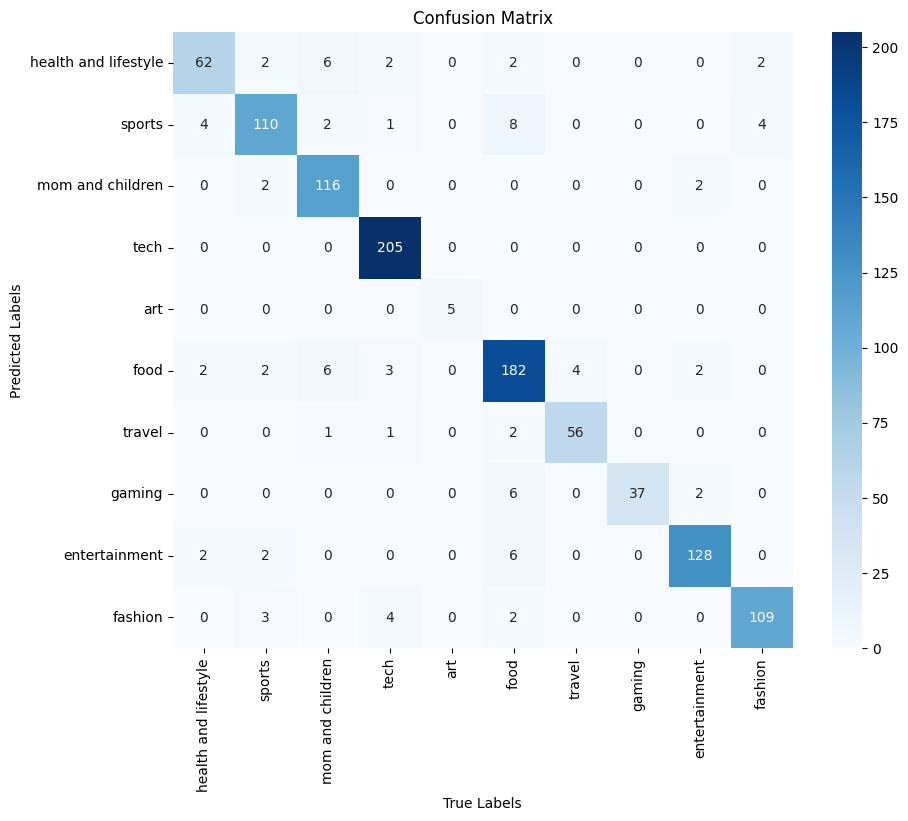

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import optuna
import matplotlib.pyplot as plt

# Optuna for hyperparameter tuning
def objective(trial):
    # Hyperparameters for Models
    svm_c = trial.suggest_float('svm_c', 0.1, 10.0, log=True)
    svm_kernel = trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf'])
    svm_gamma = trial.suggest_float('svm_gamma', 0.0001, 1.0, log=True)  

    rf_n_estimators = trial.suggest_int('rf_n_estimators', 10, 300)
    rf_max_depth = trial.suggest_int('rf_max_depth', 5, 49, step=2)
    rf_max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2', None])
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 5, 20)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 3, 20)
    rf_max_leaf_nodes = trial.suggest_int('rf_max_leaf_nodes', 10, 300)
    rf_max_samples = trial.suggest_float('rf_max_samples', 0.1, 1.0)

    lr_c = trial.suggest_float('lr_c', 0.01, 10.0, log=True)

    # Define classifiers
    svm_model = SVC(C=svm_c, 
                    kernel=svm_kernel, 
                    gamma=svm_gamma, 
                    probability=True, 
                    random_state=42, 
                    cache_size=4096)
    
    rf_model = RandomForestClassifier(n_estimators=rf_n_estimators, 
                                        max_depth=rf_max_depth, 
                                        max_features=rf_max_features,
                                        min_samples_leaf=rf_min_samples_leaf,
                                        min_samples_split=rf_min_samples_split,
                                        max_leaf_nodes=rf_max_leaf_nodes,
                                        max_samples=rf_max_samples,
                                        n_jobs=8, 
                                        random_state=42)
    
    lr_model = LogisticRegression(C=lr_c, 
                                  max_iter=1000, 
                                  n_jobs=8, 
                                  random_state=42)

    ensemble_model = VotingClassifier(
        estimators=[('svm', svm_model), ('rf', rf_model), ('lr', lr_model)],
        voting='soft'
    )

    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(ensemble_model, x_train, y_train, cv=skf, scoring='accuracy', n_jobs=8)
    return scores.mean()

# Setup the study
storage_url = "sqlite:///optuna_study.db"  

study = optuna.create_study(
    study_name="class2",   
    storage=storage_url,       
    direction="maximize",       
    load_if_exists=True         
)

# Run the optimization
study.optimize(objective, n_trials=1, show_progress_bar=True, n_jobs=10)

## Training ensemble model

Reloaded Study Best Params: {'svm_c': 9.96412445958313, 'svm_kernel': 'linear', 'svm_gamma': 0.0002067102119783412, 'rf_n_estimators': 300, 'rf_max_depth': 41, 'rf_max_features': 'log2', 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_max_leaf_nodes': 276, 'rf_max_samples': 0.30852097374093923, 'lr_c': 2.915193736936337}

#@title Train Data
Train Set Accuracy: 99.84%

Classification Report on Train Set:

                      precision    recall  f1-score   support

                 art       1.00      0.99      1.00       306
       entertainment       1.00      1.00      1.00       517
             fashion       1.00      1.00      1.00       478
                food       1.00      1.00      1.00       817
              gaming       1.00      1.00      1.00        21
health and lifestyle       0.99      1.00      1.00       803
    mom and children       1.00      1.00      1.00       238
              sports       1.00      1.00      1.00       181
                tech    

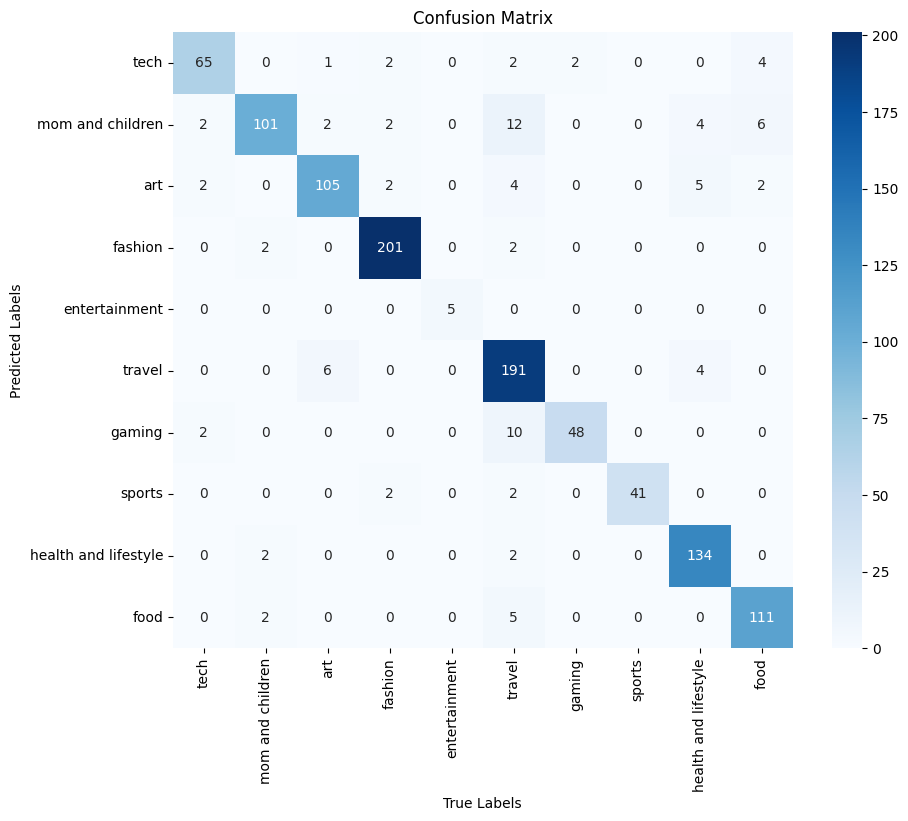

In [19]:
import optuna

storage_url = "sqlite:///optuna_study.db" 

# Load the study 
loaded_study = optuna.load_study(study_name="class2", storage=storage_url)
best_params = loaded_study.best_params

svm_model = SVC(C=best_params['svm_c'], 
                kernel=best_params['svm_kernel'], 
                gamma=best_params['svm_gamma'], 
                probability=True, 
                random_state=42,
                cache_size=4096,
                class_weight='balanced')

rf_model = RandomForestClassifier(n_estimators=best_params['rf_n_estimators'], 
                                   max_depth=best_params['rf_max_depth'], 
                                   max_features=best_params['rf_max_features'],
                                   min_samples_leaf=best_params['rf_min_samples_leaf'],
                                   min_samples_split=best_params['rf_min_samples_split'],
                                   max_leaf_nodes=best_params['rf_max_leaf_nodes'],
                                   max_samples=best_params['rf_max_samples'],
                                   n_jobs=8, 
                                   random_state=42,
                                   class_weight='balanced')


lr_model = LogisticRegression(C=best_params['lr_c'], 
                              max_iter=1000, 
                              n_jobs=8,
                              random_state=42,
                              class_weight='balanced')

ensemble_model = VotingClassifier(
    estimators=[('svm', svm_model), 
                ('rf', rf_model), 
                ('lr', lr_model)],
    voting='soft',
    n_jobs=8
)

# Train the final model on the training dataset
ensemble_model.fit(x_train, y_train)

# Evaluate on training set
y_train_pred = ensemble_model.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\n#@title Train Data")
print("Train Set Accuracy: {:.2f}%".format(train_accuracy * 100))
print("\nClassification Report on Train Set:\n")
print(classification_report(y_train, y_train_pred))

# Evaluate on test set
y_test_pred = ensemble_model.predict(x_val)
test_accuracy = accuracy_score(y_val, y_test_pred)
print("\n#@title Test Data")
print("Test Set Accuracy: {:.2f}%".format(test_accuracy * 100))
print("\nClassification Report on Test Set:\n")
print(classification_report(y_val, y_test_pred))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_val), yticklabels=set(y_val))
plt.title('Confusion Matrix')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

## Getting Output

In [ ]:
x_train = pd.DataFrame(x_train)
x_val = pd.DataFrame(x_val)

X_train_val = pd.concat([x_train, x_val])
y_train_val = pd.concat([y_train, y_val])

# Load the study 
loaded_study = optuna.load_study(study_name="class2", storage=storage_url)
best_params = loaded_study.best_params

svm_model = SVC(C=best_params['svm_c'], 
                kernel=best_params['svm_kernel'], 
                gamma=best_params['svm_gamma'], 
                probability=True, 
                random_state=42,
                cache_size=4096,
                class_weight='balanced')

rf_model = RandomForestClassifier(n_estimators=best_params['rf_n_estimators'], 
                                   max_depth=best_params['rf_max_depth'], 
                                   max_features=best_params['rf_max_features'],
                                   min_samples_leaf=best_params['rf_min_samples_leaf'],
                                   min_samples_split=best_params['rf_min_samples_split'],
                                   max_leaf_nodes=best_params['rf_max_leaf_nodes'],
                                   max_samples=best_params['rf_max_samples'],
                                   n_jobs=-1, 
                                   random_state=42,
                                   class_weight='balanced')


lr_model = LogisticRegression(C=best_params['lr_c'], 
                              max_iter=1000, 
                              n_jobs=-1,
                              random_state=42,
                              class_weight='balanced')

ensemble_model = VotingClassifier(
    estimators=[('svm', svm_model), 
                ('rf', rf_model), 
                ('lr', lr_model)],
    voting='soft',
    n_jobs=-1
)

ensemble_model.fit(X_train_val, y_train_val)

In [ ]:
test_data_path = "released_dataset/test-classification-round3.dat"

test_unames = []
with open(test_data_path, "rt") as fh:
  for line in fh:
    test_unames.append(line.strip())

x_test = []

for uname in test_unames:
  try:
    index = test_usernames.index(uname)
    x_test.append(x_post_test[index].toarray()[0])
  except Exception as e:
    try:
      index = train_usernames.index(uname)
      x_test.append(x_post_train[index].toarray()[0])
    except Exception as e:
      print(uname)

df_test = pd.DataFrame(np.array(x_test), columns=feature_names)
test_pred = ensemble_model.predict(df_test)

output = dict()
for index, uname in enumerate(test_unames):
  output[uname] = test_pred[index]
output_file_path = "prediction-classification-round3.json"
with open(output_file_path, "w") as of:
    json.dump(output, of, indent=4)
print(f"File saved to {output_file_path}")

'head' is not recognized as an internal or external command,
operable program or batch file.


*****
File saved to prediction-classification-round2.json
